In [4]:
pip install kagglehub


Note: you may need to restart the kernel to use updated packages.


In [9]:
import kagglehub

# Download latest version
data = kagglehub.dataset_download("konradb/deforestation-dataset")

print("Path to dataset files:", data)

Path to dataset files: C:\Users\gayat\.cache\kagglehub\datasets\konradb\deforestation-dataset\versions\1


In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [22]:

# Step 1: Load the dataset
data = pd.read_csv('goal15.forest_shares.csv')  # Replace with the actual path
print(data.head())  # Check the first few rows

# Step 2: Check for missing values
print("Missing values before preprocessing:")
print(data.isnull().sum())


  iso3c  forests_2000  forests_2020  trend
0   AFG           1.9           1.9    0.0
1   ALB          28.1          28.8    2.5
2   DZA           0.7           0.8   14.3
3   ASM          88.7          85.7   -3.4
4   AND          34.0          34.0    0.0
Missing values before preprocessing:
iso3c            0
forests_2000     0
forests_2020     0
trend           10
dtype: int64


In [23]:

# Step 3: Handle missing values
# Fill missing values for numeric columns with the mean
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Handle missing values in categorical columns (if any)
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])  # Fill with the most frequent value

# Check if there are any missing values left
print("Missing values after preprocessing:")
print(data.isnull().sum())

Missing values after preprocessing:
iso3c           0
forests_2000    0
forests_2020    0
trend           0
dtype: int64


In [24]:
# Step 4: Normalize numerical features
scaler = StandardScaler()
numeric_columns = ['forests_2000', 'forests_2020']  # The numeric columns that need scaling
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [25]:

# Step 5: Encode categorical variables (e.g., iso3c)
label_encoder = LabelEncoder()
data['iso3c'] = label_encoder.fit_transform(data['iso3c'])  # Encoding iso3c as numeric values

In [26]:

# Step 6: Set the target and features
X = data.drop(columns=['trend'])  # Features: iso3c, forests_2000, forests_2020
y = data['trend']  # Target: trend (binary classification)

# Step 7: Convert target to binary (0 or 1)
y = y.apply(lambda x: 1 if x > 0 else 0)

In [27]:


# Step 8: Convert to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # Reshaping to column vector

# Step 9: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


In [28]:
# Step 10: Define the model architecture (Simple Neural Network)
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)  # First layer
        self.layer2 = nn.Linear(64, 32)         # Second layer
        self.output_layer = nn.Linear(32, 1)    # Output layer

    def forward(self, x):
        x = torch.relu(self.layer1(x))           # ReLU activation
        x = torch.relu(self.layer2(x))           # ReLU activation
        x = torch.sigmoid(self.output_layer(x))  # Sigmoid activation for binary classification
        return x

In [29]:
# Initialize the model
input_dim = X_train.shape[1]  # Number of input features
model = SimpleNN(input_dim)

# Step 11: Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [30]:
# Step 12: Train the model
num_epochs = 20
loss_list = []

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/20], Loss: 1.0513
Epoch [10/20], Loss: 0.8008
Epoch [15/20], Loss: 0.8762
Epoch [20/20], Loss: 0.7389


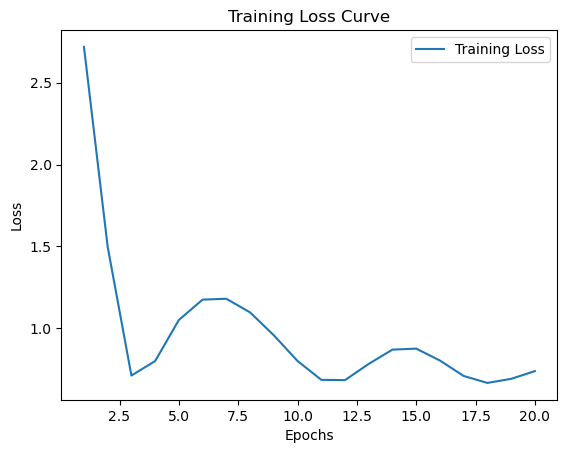

Accuracy on test set: 0.5833
              precision    recall  f1-score   support

         0.0       0.59      0.93      0.72        28
         1.0       0.50      0.10      0.17        20

    accuracy                           0.58        48
   macro avg       0.55      0.51      0.44        48
weighted avg       0.55      0.58      0.49        48



In [31]:
# Step 13: Plot training loss curve
plt.plot(range(1, num_epochs + 1), loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Step 14: Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions

# Step 15: Calculate accuracy
accuracy = (y_pred == y_test).float().mean()
print(f'Accuracy on test set: {accuracy:.4f}')

# Step 16: Generate classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.5833
Precision: 0.5000
Recall: 0.1000
F1-Score: 0.1667


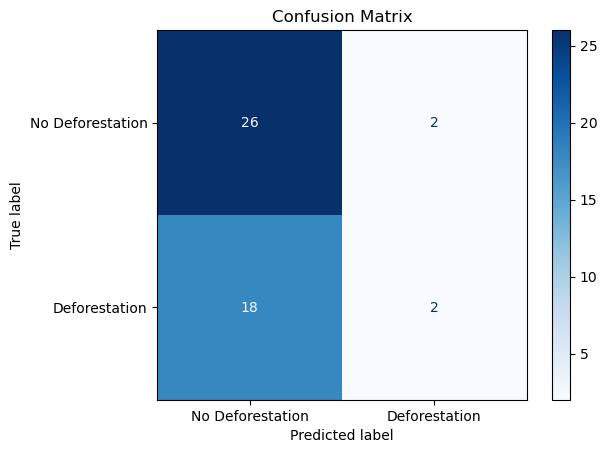


Logistic Regression Model Evaluation:
Accuracy: 0.6667
Precision: 0.7000
Recall: 0.3500
F1-Score: 0.4667


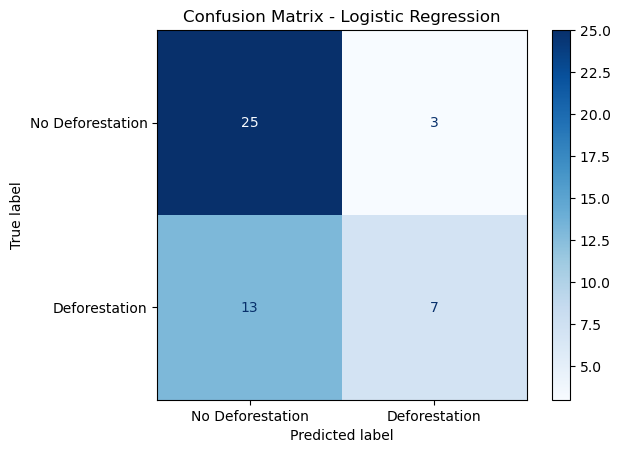


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.66      0.89      0.76        28
         1.0       0.70      0.35      0.47        20

    accuracy                           0.67        48
   macro avg       0.68      0.62      0.61        48
weighted avg       0.68      0.67      0.64        48



In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Evaluate the trained model
model.eval()
with torch.no_grad():
    # Get model predictions on the test data
    y_pred = model(X_test)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions

# Convert tensors back to numpy for sklearn evaluation
y_pred = y_pred.numpy()
y_test = y_test.numpy()

# Step 2: Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Step 3: Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Deforestation', 'Deforestation'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 4: Compare with baseline model (Logistic Regression)

# Import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train a baseline Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train.numpy(), y_train.numpy().ravel())

# Predict on test data
y_pred_baseline = log_reg.predict(X_test.numpy())

# Evaluate the baseline model
print("\nLogistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline):.4f}")

# Confusion matrix for Logistic Regression
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['No Deforestation', 'Deforestation'])
disp_baseline.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Generate classification report for Logistic Regression
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_baseline))
